# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [29]:
from lakemodel_function import lake_problem
from ema_workbench import Model, RealParameter, ScalarOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import Policy

from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework import get_SALib_problem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


mpl.rcParams['lines.markersize'] = 3
plt.style.use('seaborn-white')

In [30]:
# number of levers in the lake_model
n_levers = 100

model = Model('LakeProblem', function=lake_problem)

# specify uncertainties
model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

# specify levers
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(n_levers)]

# specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [31]:
policies = [Policy("0", **{l.name:0 for l in model.levers}),
          Policy("0.05", **{l.name:0.05 for l in model.levers}),
          Policy("0.1", **{l.name:0.1 for l in model.levers})]

In [41]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100, policies=policies , uncertainty_sampling='sobol')

experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1200 scenarios * 3 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [50]:
outcomes_names = ['max_P','utility','inertia','reliability']
policy_names = ['max_P','utility','inertia','reliability']

problem = get_SALib_problem(model.uncertainties)

n_policies = len(policies)
n_experiments = len(experiments)
n_exp_pol = n_experiments/n_policies

sa_results

for i,policy in zip(range(1,len(policies)+1),:
    result = outcomes['reliability'][int(n_exp_pol*(i-1)): int(n_exp_pol*i)]
    
    sa = sobol.analyze(problem, result,
                   calc_second_order=True, print_to_console=False)
    sa_results




In [49]:
n_exp_pol*(i-1)

0.0

In [45]:
enumerate(policies)

We have N = 1200 for each experiment, while SOBOL requires >100(k+2) where k is the number of uncertainties. This means we won't havea strong degree of stability for the SOBOL indices. We chose which uncertainties are relevant or not and then rerun with a lower need of runs.

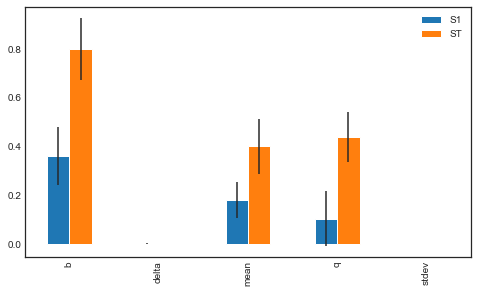

In [12]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

#sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [22]:
scores_filtered

{'ST': array([7.97495098e-01, 1.05107238e-05, 3.98555281e-01, 4.36352655e-01,
        1.15253211e-05]),
 'ST_conf': array([1.27990056e-01, 8.81204495e-06, 1.13142296e-01, 1.02451219e-01,
        7.43913373e-06]),
 'S1': array([3.60524784e-01, 8.89174675e-05, 1.78911442e-01, 1.02948915e-01,
        1.67052902e-06]),
 'S1_conf': array([0.11909252, 0.00074701, 0.07243475, 0.11159539, 0.00054686])}

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*
